# Initialization

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # for visualisation
import numpy as np
from sklearn.model_selection import cross_val_predict

In [5]:
rep = 'Downloads/sml-ht2021/'
y_train = pd.read_csv(rep + 'y_train.csv', index_col = 0, squeeze=True)
X_train = pd.read_csv(rep + 'X_train.csv', index_col = 0, header=[0, 1, 2])
X_test = pd.read_csv(rep + 'X_test.csv', index_col = 0, header=[0, 1, 2])
from sklearn.model_selection import train_test_split
inputs_train, inputs_test, targets_train, targets_test = train_test_split(X_train, y_train, test_size = 0.3)

In [130]:
inputs_train_nn = inputs_train.reset_index(drop=True)
inputs_test_nn = inputs_test.reset_index(drop=True)
targets_train_nn=targets_train.reset_index(drop=True)
targets_test_nn=targets_test.reset_index(drop=True)

# Base classifiers

## Random Forest (not used)

In [571]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

y_pred_RF = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    RF = RandomForestClassifier(n_estimators = 150, max_depth = 50, class_weight = 'balanced')
    RF_prob = RF.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    y_pred_RF = np.append(y_pred_RF, RF_prob, axis = 0)


dfRF_train = pd.DataFrame(y_pred_RF, columns = ['RF_El', 'RF_Exp', 'RF_Flk', 'RF_HH', 
                                           'RF_Inst', 'RF_Intr', 'RF_Pop', 'RF_Rck'])

RF_fitted = RF.fit(inputs_train, targets_train)

y_pred_test_RF = RF_fitted.predict_proba(inputs_test)
dfRF_test = pd.DataFrame(y_pred_test_RF, columns = ['RF_El', 'RF_Exp', 'RF_Flk', 'RF_HH', 
                                           'RF_Inst', 'RF_Intr', 'RF_Pop', 'RF_Rck'])


## Neural Nets

In [72]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim

from sklearn.preprocessing import StandardScaler

import os


# PASHA PLEASE CHECK TO MAKE SURE THIS IS THE SAME ORDER OF CLASSES AS YOU ARE USING
classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental','International', 'Pop', 'Rock']

In [124]:
class AudioDataset(Dataset):
    def __init__(self, x, y):
        super(AudioDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        x_tensor = torch.tensor(self.x.loc[index].values, dtype=torch.float)
        y_tensor = torch.tensor(self.y.loc[index], dtype=torch.long)
        return (x_tensor, y_tensor)
    
def nn_accuracy(network, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for i,d in enumerate(data_loader):
            data, labels = d
            outputs = network(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(i,predicted,labels)

    accuracy = 100 * correct / total
    return accuracy

def nn_train(net, train_dl, val_dl, SAVE_PATH, epoch_num=20, num_batches=100, 
             lr=0.01, momentum=0.9, verbose=False):
    # define the optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # enumerate epochs
    max_val_acc = 0
    for epoch in range(epoch_num):
        # enumerate mini batches
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_dl):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # training loss
            running_loss += loss.item()
            val_acc = nn_accuracy(net, val_dl)
            if val_acc > max_val_acc:
                    torch.save(net.state_dict(), SAVE_PATH)
                    max_val_acc = val_acc
            if i % num_batches == (num_batches-1): 
                tr_acc = nn_accuracy(net, train_dl)
                val_acc = nn_accuracy(net, val_dl)
                if verbose:
                    print('[EPOCH #', epoch+1,']') 
                    print('       Loss:', round(running_loss / num_batches, 3))
                    print('  Train Acc:', round(tr_acc,2), '%')
                    print('    Val Acc:', round(val_acc,2),'%')
                    print('Max Val Acc:', round(max_val_acc,2) ,'%')
                    print("------------")
                running_loss = 0.0
                

    print('Finished Training')
    print('Max Validation Acc:', max_val_acc, "%")

In [125]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(X_train.columns), 800)
        self.fc2 = nn.Linear(800, 100)
        self.fc3 = nn.Linear(100, 500)
        self.fc4 = nn.Linear(500, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 8)

    def forward(self, x):
        x = torch.celu(self.fc1(x))
        x = torch.celu(self.fc2(x),alpha=2)
        x = torch.celu(self.fc3(x),alpha=3)
        x = torch.celu(self.fc4(x),alpha=2)
        x = torch.celu(self.fc5(x))
        x = self.fc6(x)
        return x

In [126]:
def nn_train_to_prob_mat(X_train, y_train, X_test, epoch_num = 20, class_labels=classes, verbose=False):
    
    y_train = y_train.replace(classes,range(0,len(class_labels)))
    
    # normalize data
    std_scale = StandardScaler()
    X_train = std_scale.fit_transform(X_train)
    X_train = pd.DataFrame(X_train)
    X_test = std_scale.transform(X_test)
    X_test = pd.DataFrame(X_test)
    
    # make dataset
    dataset = AudioDataset(X_train,y_train)
    
    # split into train and validation set for nn training
    num_train = int(len(X_train)*.8)
    num_val = len(X_train)-num_train
    batch_size = 100
    num_batches = num_train//batch_size
    train, val = random_split(dataset, [num_train,num_val])
    
    # make dataloaders
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val, batch_size=num_val, shuffle=False)
    #test_dl = DataLoader(val, batch_size=1, shuffle=False)
    
    # make folder to save network params if does not exist
    if not os.path.exists('./NN_CV_params'):
        os.makedirs('./NN_CV_params')
    
    # train the network
    if verbose:
        print("--- BEGIN TRAINING NETWORK ---")
    net = Net()
    nn_train(net, train_dl, val_dl, './NN_CV_params/network_params.pth',epoch_num=epoch_num,
             num_batches=num_batches,verbose=verbose)
    if verbose:
        print("--- FINISHED TRAINING NETWORK ---")
    
    # generate probability matrix for test data
    prob_matrix = []
    with torch.no_grad():
        for index in range(len(X_test)):
            data = torch.tensor(X_test.loc[index].values, dtype=torch.float)
            net.load_state_dict(torch.load('./NN_CV_params/network_params.pth'))
            outputs = torch.softmax(net(data).unsqueeze(1).T, dim=1)
            prob_dist = outputs.tolist()[0]
            prob_matrix.append(prob_dist)
            
    return np.array(prob_matrix)

In [132]:
y_pred_NN = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    
    inputs_train_d = inputs_train.drop(inputs_train.index[i-840:i])
    targets_train_d = targets_train.drop(targets_train.index[i-840:i])
    inputs_train_td = inputs_train[i-840:i]
    
    inputs_train_nn = inputs_train_d.reset_index(drop=True)
    inputs_test_nn = inputs_train_td.reset_index(drop=True)
    targets_train_nn=targets_train_d.reset_index(drop=True)

    
    NN_prob = nn_train_to_prob_mat(inputs_train_nn,
                                    targets_train_nn, 
                                    inputs_test_nn, class_labels=classes, epoch_num=20, verbose=True)
    y_pred_NN = np.append(y_pred_NN, NN_prob, axis = 0)

dfNN_train = pd.DataFrame(y_pred_NN, columns = ['NN_El', 'NN_Exp', 'NN_Flk', 'NN_HH', 
                                           'NN_Inst', 'NN_Intr', 'NN_Pop', 'NN_Rck'])

inputs_train_nnf = inputs_train.reset_index(drop=True)
targets_train_nnf = targets_train.reset_index(drop=True)
inputs_test_nnf = inputs_test.reset_index(drop=True)


y_pred_test_NN = nn_train_to_prob_mat(inputs_train_nnf,
                                    targets_train_nnf, inputs_test_nnf, class_labels=classes, epoch_num=20, verbose=True)

dfNN_test = pd.DataFrame(y_pred_test_NN, columns = ['NN_El', 'NN_Exp', 'NN_Flk', 'NN_HH', 
                                           'NN_Inst', 'NN_Intr', 'NN_Pop', 'NN_Rck'])



--- BEGIN TRAINING NETWORK ---
[EPOCH # 1 ]
       Loss: 2.055
  Train Acc: 35.49 %
    Val Acc: 34.23 %
Max Val Acc: 34.23 %
------------
[EPOCH # 2 ]
       Loss: 1.86
  Train Acc: 40.18 %
    Val Acc: 37.5 %
Max Val Acc: 38.24 %
------------
[EPOCH # 3 ]
       Loss: 1.627
  Train Acc: 46.65 %
    Val Acc: 41.67 %
Max Val Acc: 41.67 %
------------
[EPOCH # 4 ]
       Loss: 1.445
  Train Acc: 50.89 %
    Val Acc: 48.07 %
Max Val Acc: 48.07 %
------------
[EPOCH # 5 ]
       Loss: 1.32
  Train Acc: 56.77 %
    Val Acc: 49.7 %
Max Val Acc: 50.3 %
------------
[EPOCH # 6 ]
       Loss: 1.226
  Train Acc: 59.93 %
    Val Acc: 51.79 %
Max Val Acc: 52.38 %
------------
[EPOCH # 7 ]
       Loss: 1.137
  Train Acc: 63.39 %
    Val Acc: 51.34 %
Max Val Acc: 52.38 %
------------
[EPOCH # 8 ]
       Loss: 1.052
  Train Acc: 67.67 %
    Val Acc: 50.6 %
Max Val Acc: 53.27 %
------------
[EPOCH # 9 ]
       Loss: 0.985
  Train Acc: 68.42 %
    Val Acc: 52.08 %
Max Val Acc: 54.32 %
------------
[EP

## Neural Net 2

In [311]:
# different activation functions
class Net2(nn.Module):
    
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(len(X_train.columns), 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 200)
        self.fc4 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 8)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [312]:
def nn_train_to_prob_mat(X_train, y_train, X_test, epoch_num = 20, class_labels=classes, verbose=False):
    
    y_train = y_train.replace(classes,range(0,len(class_labels)))
    
    # normalize data
    std_scale = StandardScaler()
    X_train = std_scale.fit_transform(X_train)
    X_train = pd.DataFrame(X_train)
    X_test = std_scale.transform(X_test)
    X_test = pd.DataFrame(X_test)
    
    # make dataset
    dataset = AudioDataset(X_train,y_train)
    
    # split into train and validation set for nn training
    num_train = int(len(X_train)*.8)
    num_val = len(X_train)-num_train
    batch_size = 100
    num_batches = num_train//batch_size
    train, val = random_split(dataset, [num_train,num_val])
    
    # make dataloaders
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val, batch_size=num_val, shuffle=False)
    #test_dl = DataLoader(val, batch_size=1, shuffle=False)
    
    # make folder to save network params if does not exist
    if not os.path.exists('./NN_CV_params'):
        os.makedirs('./NN_CV_params')
    
    # train the network
    if verbose:
        print("--- BEGIN TRAINING NETWORK ---")
    net = Net2()
    nn_train(net, train_dl, val_dl, './NN_CV_params/network_params.pth',epoch_num=epoch_num,
             num_batches=num_batches,verbose=verbose)
    if verbose:
        print("--- FINISHED TRAINING NETWORK ---")
    
    # generate probability matrix for test data
    prob_matrix = []
    with torch.no_grad():
        for index in range(len(X_test)):
            data = torch.tensor(X_test.loc[index].values, dtype=torch.float)
            net.load_state_dict(torch.load('./NN_CV_params/network_params.pth'))
            outputs = torch.softmax(net(data).unsqueeze(1).T, dim=1)
            prob_dist = outputs.tolist()[0]
            prob_matrix.append(prob_dist)
            
    return np.array(prob_matrix)

In [313]:
y_pred_NN2 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    
    inputs_train_d = inputs_train.drop(inputs_train.index[i-840:i])
    targets_train_d = targets_train.drop(targets_train.index[i-840:i])
    inputs_train_td = inputs_train[i-840:i]
    
    inputs_train_nn = inputs_train_d.reset_index(drop=True)
    inputs_test_nn = inputs_train_td.reset_index(drop=True)
    targets_train_nn=targets_train_d.reset_index(drop=True)

    
    NN_prob2 = nn_train_to_prob_mat(inputs_train_nn,
                                    targets_train_nn, 
                                    inputs_test_nn, class_labels=classes, epoch_num=20, verbose=True)
    y_pred_NN2 = np.append(y_pred_NN2, NN_prob2, axis = 0)

dfNN2_train = pd.DataFrame(y_pred_NN2, columns = ['NN2_El', 'NN2_Exp', 'NN2_Flk', 'NN2_HH', 
                                           'NN2_Inst', 'NN2_Intr', 'NN2_Pop', 'NN2_Rck'])

inputs_train_nnf = inputs_train.reset_index(drop=True)
targets_train_nnf = targets_train.reset_index(drop=True)
inputs_test_nnf = inputs_test.reset_index(drop=True)


y_pred_test_NN2 = nn_train_to_prob_mat(inputs_train_nnf,
                                    targets_train_nnf, inputs_test_nnf, class_labels=classes, epoch_num=20, verbose=True)

dfNN2_test = pd.DataFrame(y_pred_test_NN2, columns = ['NN2_El', 'NN2_Exp', 'NN2_Flk', 'NN2_HH', 
                                           'NN2_Inst', 'NN2_Intr', 'NN2_Pop', 'NN2_Rck'])

--- BEGIN TRAINING NETWORK ---
[EPOCH # 1 ]
       Loss: 2.08
  Train Acc: 13.95 %
    Val Acc: 13.69 %
Max Val Acc: 14.58 %
------------
[EPOCH # 2 ]
       Loss: 2.075
  Train Acc: 16.67 %
    Val Acc: 15.48 %
Max Val Acc: 16.82 %
------------
[EPOCH # 3 ]
       Loss: 2.068
  Train Acc: 22.58 %
    Val Acc: 23.66 %
Max Val Acc: 25.6 %
------------
[EPOCH # 4 ]
       Loss: 2.058
  Train Acc: 23.85 %
    Val Acc: 23.51 %
Max Val Acc: 25.6 %
------------
[EPOCH # 5 ]
       Loss: 2.036
  Train Acc: 24.33 %
    Val Acc: 23.66 %
Max Val Acc: 25.6 %
------------
[EPOCH # 6 ]
       Loss: 1.98
  Train Acc: 25.33 %
    Val Acc: 23.96 %
Max Val Acc: 25.6 %
------------
[EPOCH # 7 ]
       Loss: 1.884
  Train Acc: 32.22 %
    Val Acc: 31.25 %
Max Val Acc: 31.25 %
------------
[EPOCH # 8 ]
       Loss: 1.826
  Train Acc: 32.18 %
    Val Acc: 33.18 %
Max Val Acc: 33.18 %
------------
[EPOCH # 9 ]
       Loss: 1.793
  Train Acc: 32.22 %
    Val Acc: 32.89 %
Max Val Acc: 33.18 %
------------
[EP

## Neural Net 3

In [314]:

# wide network
class Net3(nn.Module):
    
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(len(X_train.columns), 60)
        self.fc2 = nn.Linear(60, 2000)
        self.fc3 = nn.Linear(2000, 600)
        self.fc4 = nn.Linear(600, 8)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.celu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x


In [315]:
def nn_train_to_prob_mat(X_train, y_train, X_test, epoch_num = 20, class_labels=classes, verbose=False):
    
    y_train = y_train.replace(classes,range(0,len(class_labels)))
    
    # normalize data
    std_scale = StandardScaler()
    X_train = std_scale.fit_transform(X_train)
    X_train = pd.DataFrame(X_train)
    X_test = std_scale.transform(X_test)
    X_test = pd.DataFrame(X_test)
    
    # make dataset
    dataset = AudioDataset(X_train,y_train)
    
    # split into train and validation set for nn training
    num_train = int(len(X_train)*.8)
    num_val = len(X_train)-num_train
    batch_size = 100
    num_batches = num_train//batch_size
    train, val = random_split(dataset, [num_train,num_val])
    
    # make dataloaders
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val, batch_size=num_val, shuffle=False)
    #test_dl = DataLoader(val, batch_size=1, shuffle=False)
    
    # make folder to save network params if does not exist
    if not os.path.exists('./NN_CV_params'):
        os.makedirs('./NN_CV_params')
    
    # train the network
    if verbose:
        print("--- BEGIN TRAINING NETWORK ---")
    net = Net3()
    nn_train(net, train_dl, val_dl, './NN_CV_params/network_params.pth',epoch_num=epoch_num,
             num_batches=num_batches,verbose=verbose)
    if verbose:
        print("--- FINISHED TRAINING NETWORK ---")
    
    # generate probability matrix for test data
    prob_matrix = []
    with torch.no_grad():
        for index in range(len(X_test)):
            data = torch.tensor(X_test.loc[index].values, dtype=torch.float)
            net.load_state_dict(torch.load('./NN_CV_params/network_params.pth'))
            outputs = torch.softmax(net(data).unsqueeze(1).T, dim=1)
            prob_dist = outputs.tolist()[0]
            prob_matrix.append(prob_dist)
            
    return np.array(prob_matrix)

In [316]:
y_pred_NN3 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    
    inputs_train_d = inputs_train.drop(inputs_train.index[i-840:i])
    targets_train_d = targets_train.drop(targets_train.index[i-840:i])
    inputs_train_td = inputs_train[i-840:i]
    
    inputs_train_nn = inputs_train_d.reset_index(drop=True)
    inputs_test_nn = inputs_train_td.reset_index(drop=True)
    targets_train_nn=targets_train_d.reset_index(drop=True)

    
    NN_prob3 = nn_train_to_prob_mat(inputs_train_nn,
                                    targets_train_nn, 
                                    inputs_test_nn, class_labels=classes, epoch_num=20, verbose=True)
    y_pred_NN3 = np.append(y_pred_NN3, NN_prob3, axis = 0)

dfNN3_train = pd.DataFrame(y_pred_NN3, columns = ['NN3_El', 'NN3_Exp', 'NN3_Flk', 'NN3_HH', 
                                           'NN3_Inst', 'NN3_Intr', 'NN3_Pop', 'NN3_Rck'])

inputs_train_nnf = inputs_train.reset_index(drop=True)
targets_train_nnf = targets_train.reset_index(drop=True)
inputs_test_nnf = inputs_test.reset_index(drop=True)


y_pred_test_NN3 = nn_train_to_prob_mat(inputs_train_nnf,
                                    targets_train_nnf, inputs_test_nnf, class_labels=classes, epoch_num=20, verbose=True)

dfNN3_test = pd.DataFrame(y_pred_test_NN3, columns = ['NN3_El', 'NN3_Exp', 'NN3_Flk', 'NN3_HH', 
                                           'NN3_Inst', 'NN3_Intr', 'NN3_Pop', 'NN3_Rck'])

--- BEGIN TRAINING NETWORK ---
[EPOCH # 1 ]
       Loss: 2.108
  Train Acc: 13.28 %
    Val Acc: 12.95 %
Max Val Acc: 14.43 %
------------
[EPOCH # 2 ]
       Loss: 2.113
  Train Acc: 12.76 %
    Val Acc: 12.95 %
Max Val Acc: 17.11 %
------------
[EPOCH # 3 ]
       Loss: 2.1
  Train Acc: 11.87 %
    Val Acc: 11.61 %
Max Val Acc: 17.11 %
------------
[EPOCH # 4 ]
       Loss: 2.061
  Train Acc: 19.31 %
    Val Acc: 17.56 %
Max Val Acc: 22.77 %
------------
[EPOCH # 5 ]
       Loss: 2.031
  Train Acc: 21.09 %
    Val Acc: 18.75 %
Max Val Acc: 26.64 %
------------
[EPOCH # 6 ]
       Loss: 1.94
  Train Acc: 28.31 %
    Val Acc: 24.55 %
Max Val Acc: 29.02 %
------------
[EPOCH # 7 ]
       Loss: 1.849
  Train Acc: 26.93 %
    Val Acc: 23.81 %
Max Val Acc: 31.4 %
------------
[EPOCH # 8 ]
       Loss: 1.794
  Train Acc: 25.37 %
    Val Acc: 26.19 %
Max Val Acc: 33.04 %
------------
[EPOCH # 9 ]
       Loss: 1.77
  Train Acc: 32.18 %
    Val Acc: 30.21 %
Max Val Acc: 35.71 %
------------
[E

## Neural Net 4

In [317]:
# deep network
# epoch num = 40
class Net4(nn.Module):
    
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(len(X_train.columns), 800)
        self.fc2 = nn.Linear(800, 100)
        self.fc3 = nn.Linear(100, 500)
        self.fc4 = nn.Linear(500, 100)
        self.fc5 = nn.Linear(100, 500)
        self.fc6 = nn.Linear(500, 100)
        self.fc7 = nn.Linear(100, 500)
        self.fc8 = nn.Linear(500, 100)
        self.fc9 = nn.Linear(100, 500)
        self.fc10 = nn.Linear(500, 100)
        self.fc11 = nn.Linear(100, 8)
        self.fc12 = nn.Linear(8, 8)

    def forward(self, x):
        x = torch.celu(self.fc1(x))
        x = torch.celu(self.fc2(x),alpha=2)
        x = torch.celu(self.fc3(x),alpha=3)
        x = torch.celu(self.fc4(x),alpha=2)
        x = torch.celu(self.fc5(x))
        x = torch.celu(self.fc6(x),alpha=.5)
        x = torch.celu(self.fc7(x),alpha=.25)
        x = torch.celu(self.fc8(x),alpha=.5)
        x = torch.celu(self.fc9(x))
        x = torch.celu(self.fc10(x))
        x = torch.celu(self.fc11(x))
        x = self.fc12(x)
        return x

In [318]:
def nn_train_to_prob_mat(X_train, y_train, X_test, epoch_num = 40, class_labels=classes, verbose=False):
    
    y_train = y_train.replace(classes,range(0,len(class_labels)))
    
    # normalize data
    std_scale = StandardScaler()
    X_train = std_scale.fit_transform(X_train)
    X_train = pd.DataFrame(X_train)
    X_test = std_scale.transform(X_test)
    X_test = pd.DataFrame(X_test)
    
    # make dataset
    dataset = AudioDataset(X_train,y_train)
    
    # split into train and validation set for nn training
    num_train = int(len(X_train)*.8)
    num_val = len(X_train)-num_train
    batch_size = 100
    num_batches = num_train//batch_size
    train, val = random_split(dataset, [num_train,num_val])
    
    # make dataloaders
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val, batch_size=num_val, shuffle=False)
    #test_dl = DataLoader(val, batch_size=1, shuffle=False)
    
    # make folder to save network params if does not exist
    if not os.path.exists('./NN_CV_params'):
        os.makedirs('./NN_CV_params')
    
    # train the network
    if verbose:
        print("--- BEGIN TRAINING NETWORK ---")
    net = Net4()
    nn_train(net, train_dl, val_dl, './NN_CV_params/network_params.pth',epoch_num=epoch_num,
             num_batches=num_batches,verbose=verbose)
    if verbose:
        print("--- FINISHED TRAINING NETWORK ---")
    
    # generate probability matrix for test data
    prob_matrix = []
    with torch.no_grad():
        for index in range(len(X_test)):
            data = torch.tensor(X_test.loc[index].values, dtype=torch.float)
            net.load_state_dict(torch.load('./NN_CV_params/network_params.pth'))
            outputs = torch.softmax(net(data).unsqueeze(1).T, dim=1)
            prob_dist = outputs.tolist()[0]
            prob_matrix.append(prob_dist)
            
    return np.array(prob_matrix)

In [319]:
y_pred_NN4 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    
    inputs_train_d = inputs_train.drop(inputs_train.index[i-840:i])
    targets_train_d = targets_train.drop(targets_train.index[i-840:i])
    inputs_train_td = inputs_train[i-840:i]
    
    inputs_train_nn = inputs_train_d.reset_index(drop=True)
    inputs_test_nn = inputs_train_td.reset_index(drop=True)
    targets_train_nn=targets_train_d.reset_index(drop=True)

    
    NN_prob4 = nn_train_to_prob_mat(inputs_train_nn,
                                    targets_train_nn, 
                                    inputs_test_nn, class_labels=classes, epoch_num=40, verbose=True)
    y_pred_NN4 = np.append(y_pred_NN4, NN_prob4, axis = 0)

dfNN4_train = pd.DataFrame(y_pred_NN4, columns = ['NN4_El', 'NN4_Exp', 'NN4_Flk', 'NN4_HH', 
                                           'NN4_Inst', 'NN4_Intr', 'NN4_Pop', 'NN4_Rck'])

inputs_train_nnf = inputs_train.reset_index(drop=True)
targets_train_nnf = targets_train.reset_index(drop=True)
inputs_test_nnf = inputs_test.reset_index(drop=True)


y_pred_test_NN4 = nn_train_to_prob_mat(inputs_train_nnf,
                                    targets_train_nnf, inputs_test_nnf, class_labels=classes, epoch_num=40, verbose=True)

dfNN4_test = pd.DataFrame(y_pred_test_NN4, columns = ['NN4_El', 'NN4_Exp', 'NN4_Flk', 'NN4_HH', 
                                           'NN4_Inst', 'NN4_Intr', 'NN4_Pop', 'NN4_Rck'])

--- BEGIN TRAINING NETWORK ---
[EPOCH # 1 ]
       Loss: 2.091
  Train Acc: 13.17 %
    Val Acc: 12.5 %
Max Val Acc: 12.5 %
------------
[EPOCH # 2 ]
       Loss: 2.084
  Train Acc: 13.17 %
    Val Acc: 12.5 %
Max Val Acc: 12.5 %
------------
[EPOCH # 3 ]
       Loss: 2.08
  Train Acc: 13.28 %
    Val Acc: 13.24 %
Max Val Acc: 13.84 %
------------
[EPOCH # 4 ]
       Loss: 2.078
  Train Acc: 13.17 %
    Val Acc: 12.5 %
Max Val Acc: 13.84 %
------------
[EPOCH # 5 ]
       Loss: 2.078
  Train Acc: 12.98 %
    Val Acc: 10.42 %
Max Val Acc: 13.84 %
------------
[EPOCH # 6 ]
       Loss: 2.077
  Train Acc: 13.13 %
    Val Acc: 12.8 %
Max Val Acc: 13.84 %
------------
[EPOCH # 7 ]
       Loss: 2.076
  Train Acc: 17.26 %
    Val Acc: 13.54 %
Max Val Acc: 16.52 %
------------
[EPOCH # 8 ]
       Loss: 2.076
  Train Acc: 17.22 %
    Val Acc: 13.24 %
Max Val Acc: 16.82 %
------------
[EPOCH # 9 ]
       Loss: 2.075
  Train Acc: 16.63 %
    Val Acc: 13.1 %
Max Val Acc: 16.82 %
------------
[EPOC

## XGBoost 1

In [43]:
#XGBoost1
from xgboost import XGBClassifier

y_pred_XGB = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    XGB = XGBClassifier(
     learning_rate =0.1,
     n_estimators=320,
     max_depth=7,
     min_child_weight=5,
     gamma=0,
     subsample=0.6,
     colsample_bytree=0.5,
     reg_alpha = 0.1,
     reg_lambda = 1,
     objective= 'multi:softmax',
     num_class = 8,
     n_jobs=-1,
     scale_pos_weight=1,
     seed=27)
    XGB_prob = XGB.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    y_pred_XGB = np.append(y_pred_XGB, XGB_prob, axis = 0)
    

dfXGB_train = pd.DataFrame(y_pred_XGB, columns = ['XGB1_El', 'XGB1_Exp', 'XGB1_Flk', 'XGB1_HH', 
                                           'XGB1_Inst', 'XGB1_Intr', 'XGB1_Pop', 'XGB1_Rck'])

XGB_fitted = XGB.fit(inputs_train, targets_train)

y_pred_test_XGB = XGB_fitted.predict_proba(inputs_test)
dfXGB_test = pd.DataFrame(y_pred_test_XGB, columns = ['XGB1_El', 'XGB1_Exp', 'XGB1_Flk', 'XGB1_HH', 
                                           'XGB1_Inst', 'XGB1_Intr', 'XGB1_Pop', 'XGB1_Rck'])


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:52:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find 

## XGBoost 2

In [44]:
#XGBoost2

y_pred_XGB2 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    XGB2 = XGBClassifier(
     learning_rate =0.1,
        n_estimators=320,
        max_depth=7,
        min_child_weight=5,
        gamma=0.2,
        subsample=0.6,
        colsample_bytree=0.4,
        reg_alpha = 0.1,
        reg_lambda = 1,
        objective= 'multi:softmax',
        num_class = 8,
        n_jobs=-1,
        scale_pos_weight=1,
        seed=27)
    XGB2_prob = XGB2.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    y_pred_XGB2 = np.append(y_pred_XGB2, XGB2_prob, axis = 0)
    
dfXGB2_train = pd.DataFrame(y_pred_XGB2, columns = ['XGB2_El', 'XGB2_Exp', 'XGB2_Flk', 'XGB2_HH', 
                                           'XGB2_Inst', 'XGB2_Intr', 'XGB2_Pop', 'XGB2_Rck'])

XGB2_fitted = XGB2.fit(inputs_train, targets_train)

y_pred_test_XGB2 = XGB2_fitted.predict_proba(inputs_test)
dfXGB2_test = pd.DataFrame(y_pred_test_XGB2, columns = ['XGB2_El', 'XGB2_Exp', 'XGB2_Flk', 'XGB2_HH', 
                                           'XGB2_Inst', 'XGB2_Intr', 'XGB2_Pop', 'XGB2_Rck'])



[13:57:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:57:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find 

## XGBoost 3

In [45]:
#XGBoost3

y_pred_XGB3 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    XGB3 = XGBClassifier(
     learning_rate =0.1,
      n_estimators=320,
      max_depth=3,
      min_child_weight=5,
      gamma=0,
      subsample=0.6,
      colsample_bytree=0.5,
      reg_alpha = 1,
      reg_lambda = 1,
      objective= 'multi:softmax',
      num_class = 8,
      n_jobs=-1,
      scale_pos_weight=1,
      seed=27)

    XGB3_prob = XGB3.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    
    y_pred_XGB3 = np.append(y_pred_XGB3, XGB3_prob, axis = 0)

dfXGB3_train = pd.DataFrame(y_pred_XGB3, columns = ['XGB3_El', 'XGB3_Exp', 'XGB3_Flk', 'XGB3_HH', 
                                           'XGB3_Inst', 'XGB3_Intr', 'XGB3_Pop', 'XGB3_Rck'])

XGB3_fitted = XGB3.fit(inputs_train, targets_train)

y_pred_test_XGB3 = XGB3_fitted.predict_proba(inputs_test)
dfXGB3_test = pd.DataFrame(y_pred_test_XGB3, columns = ['XGB3_El', 'XGB3_Exp', 'XGB3_Flk', 'XGB3_HH', 
                                           'XGB3_Inst', 'XGB3_Intr', 'XGB3_Pop', 'XGB3_Rck'])

[14:02:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:02:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find 

## XGBoost 4


In [336]:
y_pred_XGB4 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    XGB4 = XGBClassifier(
         learning_rate =0.1,
         n_estimators=235,
         max_depth=5,
         min_child_weight=2,
         gamma=0,
         reg_lambda=1,
         subsample=0.75,
         colsample_bytree=0.75,
         colsample_bynode = 0.75,
         objective= 'multi:softmax',
         num_class = 8,
         n_jobs=-1,
         seed=27)


    XGB4_prob = XGB4.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    
    y_pred_XGB4 = np.append(y_pred_XGB4, XGB4_prob, axis = 0)

dfXGB4_train = pd.DataFrame(y_pred_XGB4, columns = ['XGB4_El', 'XGB4_Exp', 'XGB4_Flk', 'XGB4_HH', 
                                           'XGB4_Inst', 'XGB4_Intr', 'XGB4_Pop', 'XGB4_Rck'])

XGB4_fitted = XGB4.fit(inputs_train, targets_train)

y_pred_test_XGB4 = XGB4_fitted.predict_proba(inputs_test)
dfXGB4_test = pd.DataFrame(y_pred_test_XGB4, columns = ['XGB4_El', 'XGB4_Exp', 'XGB4_Flk', 'XGB4_HH', 
                                           'XGB4_Inst', 'XGB4_Intr', 'XGB4_Pop', 'XGB4_Rck'])

[20:06:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

## Linear Discriminant Analysis

In [46]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

y_pred_LDA = np.empty(shape = (0,8))
for i in [840, 1680, 2520, 3360, 4200]:
    LDA = LinearDiscriminantAnalysis(solver = "eigen", shrinkage = 'auto')

    LDA_prob = LDA.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    
    y_pred_LDA = np.append(y_pred_LDA, LDA_prob, axis = 0)
    
dfLDA_train = pd.DataFrame(y_pred_LDA, columns = ['LDA_El', 'LDA_Exp', 'LDA_Flk', 'LDA_HH', 
                                           'LDA_Inst', 'LDA_Intr', 'LDA_Pop', 'LDA_Rck'])

LDA_fitted = LDA.fit(inputs_train, targets_train)

y_pred_test_LDA = LDA_fitted.predict_proba(inputs_test)
dfLDA_test = pd.DataFrame(y_pred_test_LDA, columns = ['LDA_El', 'LDA_Exp', 'LDA_Flk', 'LDA_HH', 
                                           'LDA_Inst', 'LDA_Intr', 'LDA_Pop', 'LDA_Rck'])


## Quadratic Discriminant Analysis

In [52]:
#QDA

#PCA data preparation


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
inputs_train_sc = scaler.transform(inputs_train)
inputs_test_sc = scaler.transform(inputs_test)
X_train_sc = scaler.transform(X_train)

from sklearn.decomposition import PCA

pca = PCA(n_components = 200)
pca.fit(X_train_sc)
inputs_train_pca = pca.transform(inputs_train_sc)
inputs_test_pca = pca.transform(inputs_test_sc)

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

y_pred_QDA = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    QDA = QuadraticDiscriminantAnalysis()
    QDA_prob = QDA.fit(np.delete(inputs_train_pca, slice(i-840, i), axis = 0), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train_pca[i-840:i])

    y_pred_QDA = np.append(y_pred_QDA, QDA_prob, axis = 0)
    
dfQDA_train = pd.DataFrame(y_pred_QDA, columns = ['QDA_El', 'QDA_Exp', 'QDA_Flk', 'QDA_HH', 
                                           'QDA_Inst', 'QDA_Intr', 'QDA_Pop', 'QDA_Rck'])

QDA_fitted = QDA.fit(inputs_train_pca, targets_train)

y_pred_test_QDA = QDA_fitted.predict_proba(inputs_test_pca)
dfQDA_test = pd.DataFrame(y_pred_test_QDA, columns = ['QDA_El', 'QDA_Exp', 'QDA_Flk', 'QDA_HH', 
                                           'QDA_Inst', 'QDA_Intr', 'QDA_Pop', 'QDA_Rck'])

In [514]:
y_pred_QDA2 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    
    LDA_transform = LinearDiscriminantAnalysis(n_components = 8 - 1)
    LDA_transform.fit(np.delete(inputs_train_sc, slice(i-840, i), axis = 0), targets_train.drop(targets_train.index[i-840:i]))
    inputs_train_lda = LDA_transform.transform(np.delete(inputs_train_sc, slice(i-840, i), axis = 0))
    inputs_test_lda = LDA_transform.transform(inputs_train_sc[i-840:i])
    
    QDA2 = QuadraticDiscriminantAnalysis()
    QDA2_prob = QDA.fit(inputs_train_lda, 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_test_lda)

    y_pred_QDA2 = np.append(y_pred_QDA2, QDA2_prob, axis = 0)

    
dfQDA2_train = pd.DataFrame(y_pred_QDA2, columns = ['QDA2_El', 'QDA2_Exp', 'QDA2_Flk', 'QDA2_HH', 
                                           'QDA2_Inst', 'QDA2_Intr', 'QDA2_Pop', 'QDA2_Rck'])

LDA_transform = LinearDiscriminantAnalysis(n_components = 8 - 1)
LDA_transform.fit(inputs_train_sc, targets_train)
inputs_train_lda = LDA_transform.transform(inputs_train_sc)
inputs_test_lda = LDA_transform.transform(inputs_test_sc)

QDA2_fitted = QDA2.fit(inputs_train_lda, targets_train)

y_pred_test_QDA2 = QDA2_fitted.predict_proba(inputs_test_lda)
dfQDA2_test = pd.DataFrame(y_pred_test_QDA2, columns = ['QDA2_El', 'QDA2_Exp', 'QDA2_Flk', 'QDA2_HH', 
                                           'QDA2_Inst', 'QDA2_Intr', 'QDA2_Pop', 'QDA2_Rck'])

## K-nearest neighbours 

In [62]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

y_pred_KNN = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:

    KNN = KNeighborsClassifier(n_neighbors=20)

    KNN_prob = KNN.fit(np.delete(inputs_train_sc, slice(i-840, i), axis = 0), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train_sc[i-840:i])
    
    y_pred_KNN = np.append(y_pred_KNN, KNN_prob, axis = 0)
    
dfKNN_train = pd.DataFrame(y_pred_KNN, columns = ['KNN_El', 'KNN_Exp', 'KNN_Flk', 'KNN_HH', 
                                           'KNN_Inst', 'KNN_Intr', 'KNN_Pop', 'KNN_Rck'])

KNN_fitted = KNN.fit(inputs_train_sc, targets_train)

y_pred_test_KNN = KNN_fitted.predict_proba(inputs_test_sc)
dfKNN_test = pd.DataFrame(y_pred_test_KNN, columns = ['KNN_El', 'KNN_Exp', 'KNN_Flk', 'KNN_HH', 
                                           'KNN_Inst', 'KNN_Intr', 'KNN_Pop', 'KNN_Rck'])


## Logistic regression

In [54]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

y_pred_LR = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    LR = LogisticRegression(max_iter = 50)
    
    LR_prob = LR.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    
    y_pred_LR = np.append(y_pred_LR, LR_prob, axis = 0)
    
dfLR_train = pd.DataFrame(y_pred_LR, columns = ['LR_El', 'LR_Exp', 'LR_Flk', 'LR_HH', 
                                           'LR_Inst', 'LR_Intr', 'LR_Pop', 'LR_Rck'])

LR_fitted = LR.fit(inputs_train, targets_train)

y_pred_test_LR = LR_fitted.predict_proba(inputs_test)
dfLR_test = pd.DataFrame(y_pred_test_LR, columns = ['LR_El', 'LR_Exp', 'LR_Flk', 'LR_HH', 
                                           'LR_Inst', 'LR_Intr', 'LR_Pop', 'LR_Rck'])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

## Naive Bayes

In [55]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

y_pred_NB = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:
    NB = GaussianNB()
    
    NB_prob = NB.fit(inputs_train.drop(inputs_train.index[i-840:i]), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train[i-840:i])
    
    y_pred_NB = np.append(y_pred_NB, NB_prob, axis = 0)
    
    
dfNB_train = pd.DataFrame(y_pred_NB, columns = ['NB_El', 'NB_Exp', 'NB_Flk', 'NB_HH', 
                                           'NB_Inst', 'NB_Intr', 'NB_Pop', 'NB_Rck'])

NB_fitted = NB.fit(inputs_train, targets_train)

y_pred_test_NB = NB_fitted.predict_proba(inputs_test)

dfNB_test = pd.DataFrame(y_pred_test_NB, columns = ['NB_El', 'NB_Exp', 'NB_Flk', 'NB_HH', 
                                           'NB_Inst', 'NB_Intr', 'NB_Pop', 'NB_Rck'])


## Extra Trees

In [56]:
#Extratrees 
from sklearn.ensemble import ExtraTreesClassifier

indices = pd.read_csv('Downloads/RF_indices.csv', index_col = 0, squeeze=True).to_numpy()
i = 190
ind = indices[0:i :]
inputs_train_rf = inputs_train_sc[:,ind]
inputs_test_rf = inputs_test_sc[:,ind]


y_pred_XTR = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:

    XTR = ExtraTreesClassifier(warm_start = True, n_estimators = 840, max_features = None, min_samples_split = 2, 
                          random_state = 102)
    
    XTR_prob = XTR.fit(np.delete(inputs_train_rf, slice(i-840, i), axis = 0), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train_rf[i-840:i])
    
    y_pred_XTR = np.append(y_pred_XTR, XTR_prob, axis = 0)

dfXTR_train = pd.DataFrame(y_pred_XTR, columns = ['XTR_El', 'XTR_Exp', 'XTR_Flk', 'XTR_HH', 
                                           'XTR_Inst', 'XTR_Intr', 'XTR_Pop', 'XTR_Rck'])

XTR_fitted = XTR.fit(inputs_train_rf, targets_train)

y_pred_test_XTR = XTR_fitted.predict_proba(inputs_test_rf)

dfXTR_test = pd.DataFrame(y_pred_test_XTR, columns = ['XTR_El', 'XTR_Exp', 'XTR_Flk', 'XTR_HH', 
                                           'XTR_Inst', 'XTR_Intr', 'XTR_Pop', 'XTR_Rck'])



/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


## Extra Trees 2

In [350]:
indices_2 = pd.read_csv('Downloads/indices_1.csv', index_col = 0, squeeze=True).to_numpy()
i = 190
ind_2 = indices_2[0:i :]
inputs_train_rf = inputs_train_sc[:,ind_2]
inputs_test_rf = inputs_test_sc[:,ind_2]

y_pred_XTR2 = np.empty(shape = (0,8))

for i in [840, 1680, 2520, 3360, 4200]:

    XTR2 = RandomForestClassifier(n_estimators = 900, min_samples_split = 2, random_state = 2, max_depth = 30)
    
    XTR2_prob = XTR2.fit(np.delete(inputs_train_rf, slice(i-840, i), axis = 0), 
                       targets_train.drop(targets_train.index[i-840:i])).predict_proba(inputs_train_rf[i-840:i])
    
    y_pred_XTR2 = np.append(y_pred_XTR2, XTR2_prob, axis = 0)

dfXTR2_train = pd.DataFrame(y_pred_XTR2, columns = ['XTR2_El', 'XTR2_Exp', 'XTR2_Flk', 'XTR2_HH', 
                                           'XTR2_Inst', 'XTR2_Intr', 'XTR2_Pop', 'XTR2_Rck'])

XTR2_fitted = XTR2.fit(inputs_train_rf, targets_train)

y_pred_test_XTR2 = XTR2_fitted.predict_proba(inputs_test_rf)

dfXTR2_test = pd.DataFrame(y_pred_test_XTR2, columns = ['XTR2_El', 'XTR2_Exp', 'XTR2_Flk', 'XTR2_HH', 
                                           'XTR2_Inst', 'XTR2_Intr', 'XTR2_Pop', 'XTR2_Rck'])


# Probability matrix combination

In [616]:
pred_proba_train_t = pd.concat([dfXGB_train, dfLDA_train, dfQDA_train, 
                              dfKNN_train, dfLR_train, dfXGB2_train, dfXGB3_train, dfNB_train, 
                                dfXTR_train, dfNN_train],
                               axis = 1 )
pred_proba_test_t = pd.concat([dfXGB_test, dfLDA_test, dfQDA_test,
                            dfKNN_test, dfLR_test, dfXGB2_test, dfXGB3_test,  dfNB_test, 
                               dfXTR_test, dfNN_test], axis = 1)


# Top-level classifiers

## Logistic Regression

In [539]:
log_reg = LogisticRegression(max_iter = 200)
Log_reg_fitted = log_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', Log_reg_fitted.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', Log_reg_fitted.score(pred_proba_test_t, targets_test))

Prediction accuracy IS:  0.6302380952380953
Prediction accuracy OS:  0.6394444444444445


## Linear Discriminant Analysis

In [540]:
LDA_reg = LinearDiscriminantAnalysis(solver = "eigen", shrinkage = 'auto')
LDA_reg_fitted = LDA_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', LDA_reg_fitted.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', LDA_reg_fitted.score(pred_proba_test_t, targets_test))


Prediction accuracy IS:  0.6204761904761905
Prediction accuracy OS:  0.6333333333333333


## XGBoost 1

In [610]:
XGB_reg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=320,
 max_depth=7,
 min_child_weight=5,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.5,
 reg_alpha = 0.1,
 reg_lambda = 1,
 objective= 'multi:softmax',
 num_class = 8,
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27)

XGB_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', XGB_reg.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', XGB_reg.score(pred_proba_test_t, targets_test))


[15:13:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:13:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction accuracy IS:  0.9997619047619047
Prediction accuracy OS:  0.63


## Naive Bayes

In [542]:
NB_reg = GaussianNB()
NB_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', NB_reg.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', NB_reg.score(pred_proba_test_t, targets_test))


Prediction accuracy IS:  0.5919047619047619
Prediction accuracy OS:  0.6016666666666667


## Random Forest

In [543]:
RF_reg = RandomForestClassifier(n_estimators = 50, max_depth = 10, class_weight = 'balanced')
RF_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', RF_reg.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', RF_reg.score(pred_proba_test_t, targets_test))


Prediction accuracy IS:  0.7904761904761904
Prediction accuracy OS:  0.6244444444444445


## XGBoost 2

In [611]:
XGB2_reg = XGBClassifier(
 learning_rate =0.1,
    n_estimators=320,
    max_depth=7,
    min_child_weight=5,
    gamma=0.2,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_alpha = 0.1,
    reg_lambda = 1,
    objective= 'multi:softmax',
    num_class = 8,
    n_jobs=-1,
    scale_pos_weight=1,
    seed=27)
XGB2_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', XGB2_reg.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', XGB2_reg.score(pred_proba_test_t, targets_test))

[15:13:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:13:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction accuracy IS:  0.9997619047619047
Prediction accuracy OS:  0.6238888888888889


## XGBoost 3

In [615]:
XGB3_reg = XGBClassifier(
 learning_rate =0.1,
  n_estimators=320,
  max_depth=3,
  min_child_weight=5,
  gamma=0,
  subsample=0.6,
  colsample_bytree=0.5,
  reg_alpha = 1,
  reg_lambda = 1,
  objective= 'multi:softmax',
  num_class = 8,
  n_jobs=-1,
  scale_pos_weight=1,
  seed=27)
XGB3_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', XGB3_reg.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', XGB3_reg.score(pred_proba_test_t, targets_test))

[15:22:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:22:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction accuracy IS:  0.9252380952380952
Prediction accuracy OS:  0.6327777777777778


## XGBoost 4

In [613]:
XGB4_reg = XGBClassifier(
    learning_rate =0.1,
         n_estimators=235,
         max_depth=5,
         min_child_weight=2,
         gamma=0,
         reg_lambda=1,
         subsample=0.75,
         colsample_bytree=0.75,
         colsample_bynode = 0.75,
         objective= 'multi:softmax',
         num_class = 8,
         n_jobs=-1,
         seed=27)
XGB4_reg.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', XGB4_reg.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', XGB4_reg.score(pred_proba_test_t, targets_test))

[15:14:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction accuracy IS:  0.9997619047619047
Prediction accuracy OS:  0.6322222222222222


## Xtra Trees Classifier

In [597]:
XTR_reg = ExtraTreesClassifier(warm_start = True, n_estimators = 840, max_features = None, min_samples_split = 2, 
                          random_state = 102)
XTR_fitted = XTR_reg.fit(pred_proba_train_t, targets_train)

print('Prediction accuracy IS: ', XTR_fitted.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', XTR_fitted.score(pred_proba_test_t, targets_test))

Prediction accuracy IS:  0.9997619047619047
Prediction accuracy OS:  0.635


## XGB simple Classifier

In [596]:
from xgboost import cv
from xgboost import DMatrix
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(targets_train)
label_encoded_y_train = label_encoder.transform(targets_train)

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 objective= 'multi:softmax',
 num_class = 8)

xgb_param = xgb.get_xgb_params()

xgtrain = DMatrix(pred_proba_train_t, label = label_encoded_y_train)

cvresult3 = cv(xgb_param, xgtrain, num_boost_round=xgb.get_params()['n_estimators'], nfold=5,
        early_stopping_rounds=25, verbose_eval = 25, metrics = 'merror')

xgb.set_params(n_estimators=cvresult3.shape[0])

xgb.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', xgb.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', xgb.score(pred_proba_test_t, targets_test))



[14:20:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction accuracy IS:  0.9614285714285714
Prediction accuracy OS:  0.6344444444444445


## XGB simple Classifier

In [486]:
xgbCC = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 objective= 'multi:softmax',
 num_class = 8)

xgbCC.fit(pred_proba_train_t, targets_train)
print('Prediction accuracy IS: ', xgbCC.score(pred_proba_train_t, targets_train))
print('Prediction accuracy OS: ', xgbCC.score(pred_proba_test_t, targets_test))

[13:44:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction accuracy IS:  0.9997619047619047
Prediction accuracy OS:  0.5722222222222222


# Plotting confusion matrix

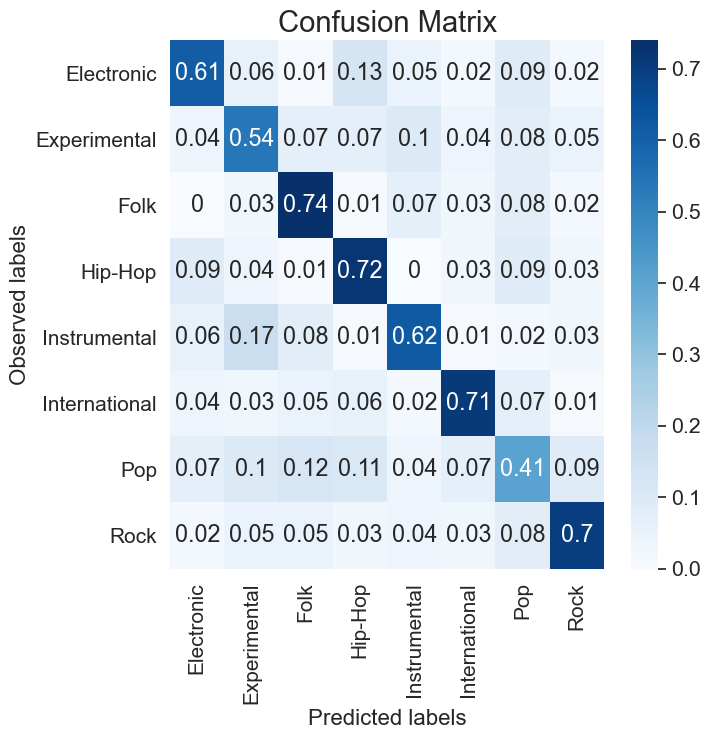

In [598]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7, 7), dpi = 100)
from sklearn.metrics import confusion_matrix
y_hat = XGB3_reg.predict(pred_proba_test_t)
cm = confusion_matrix(y_true = targets_test, y_pred = y_hat, normalize = 'true')
cm = np.round(cm, 2)

ax = plt.subplot()
sns.set(font_scale=1.4) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

label_font = {'size':'10'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontsize= 16);
ax.set_ylabel('Observed labels', fontsize= 16);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
ax.xaxis.set_ticklabels(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International','Pop', 'Rock']);
ax.yaxis.set_ticklabels(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International','Pop', 'Rock']);
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

array([[0.66, 0.04, 0.  , 0.09, 0.05, 0.03, 0.11, 0.01],
       [0.04, 0.54, 0.08, 0.05, 0.09, 0.03, 0.1 , 0.06],
       [0.01, 0.03, 0.7 , 0.01, 0.08, 0.03, 0.1 , 0.03],
       [0.11, 0.02, 0.  , 0.68, 0.  , 0.05, 0.1 , 0.03],
       [0.06, 0.14, 0.06, 0.  , 0.67, 0.01, 0.04, 0.03],
       [0.06, 0.04, 0.02, 0.05, 0.02, 0.71, 0.08, 0.02],
       [0.07, 0.09, 0.11, 0.11, 0.05, 0.07, 0.41, 0.09],
       [0.03, 0.07, 0.05, 0.02, 0.04, 0.02, 0.09, 0.68]])

In [259]:
XGB_reg_fitted_fi = XGB_reg.fit(pred_proba_train_t, targets_train)

[14:59:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:59:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
importances_XGB = XGB_fitted.feature_importances_
top_features = np.argsort(importances_XGB)[-80:]
pred_proba_train_t.iloc[:, top_features]

In [281]:
#XGB1
sum(importances_XGB[0:8])

0.15148406196385622

In [282]:
#LDA
sum(importances_XGB[8:16])

0.09628592617809772

In [283]:
#QDA
sum(importances_XGB[16:24])

0.07046711537986994

In [286]:
#KNN
sum(importances_XGB[24:32])

0.07924075983464718

In [285]:
#LR
sum(importances_XGB[32:40])

0.06241098418831825

In [287]:
#XGB2
sum(importances_XGB[40:48])

0.15150816831737757

In [288]:
#XGB3
sum(importances_XGB[48:56])

0.13309240993112326

In [289]:
#NB
sum(importances_XGB[56:64])

0.06814045924693346

In [290]:
#XTR
sum(importances_XGB[64:72])

0.11019650101661682

In [291]:
#NN
sum(importances_XGB[72:80])

0.07717357855290174

In [ ]:
LDA_transform = LinearDiscriminantAnalysis(n_components = 8 - 1)
LDA_transform.fit(inputs_train_sc, targets_train)
inputs_train_lda = LDA_transform.transform(inputs_train_sc)
inputs_test_lda = LDA_transform.transform(inputs_test_sc)

In [ ]:
plot_confusion_matrix(X = targets_test, y_pred = y_hat)